# Extracting Metrics

**Where we start:**
This notebook is the last one in the data analysis pipeline described in our [blog post][blog_post_link].

We assume that you went through both the notebook describing how to [Define Nested AOIs][nested_aois_link] and the notebook describing how to [Define Distributed AOIs][distributed_aois_link]. You should have created two csv files that contain the fixation data from either one reference image (nested AOIs), or several reference images (distributed AOIs) with an additional column 'AOI' that defines to which AOI each fixation was made. These files should be in the same directory from where you execute this notebook.

If you want to save the figures from this notebook, you need to have folder "figures" in the same directory.

With this notebook we can look at metrics from both nested aois (which we defined on reference images in the standing condition), and from distributed AOIs (which we defined on reference images in the walking condition). These two conditions will differ in some fundamental properties, like the length of recordings, length of sections and the time that participants stood in front of each image. Always keep the condition in which data was recorded in mind when trying to interpret the metrics from this notebook.

**Dependencies:**
[matplotlib][matplotlib_link], [OpenCV][opencv_link], [pandas][pandas_link], [numpy][numpy_link] and [seaborn][seaborn_link] are installed.

**What we do:**
We aggregate the csv files in several ways to produce summary statistics of how observers explored different AOIs. We will visualize those summaries with seaborn.

**What we get:**
Figures from 3 different metrics: Hit Rate, Time to First Contact, and Dwell Time. The figures show mean values as well as data points from individual subjects for a better estimation of the variability in the data.


[nested_aois_link]: https://github.com/pupil-labs/gallery_demo_analysis/blob/main/Defining%20Nested%20AOIs.ipynb
[distributed_aois_link]: https://github.com/pupil-labs/gallery_demo_analysis/blob/main/Defining%20Distributed%20AOIs.ipynb
[matplotlib_link]: https://matplotlib.org/ 
[opencv_link]: https://opencv.org/
[pandas_link]: https://pandas.pydata.org/
[numpy_link]: https://numpy.org/
[seaborn_link]: https://seaborn.pydata.org/

## Import Needed Libraries and Define Paths

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from PIL import Image

# ACTION NEEDED: define if you are working with nested or distributed AOIs
aoi_layout = "nested"

# define the path and a color map
if aoi_layout == "distributed":
    palette = "viridis"
    # ACTION NEEDED: set the path on your pc
    path_to_reference_image_mapper = "./reference_image_enrichments/"
elif aoi_layout == "nested":
    palette = "plasma"
    # ACTION NEEDED: set the path on your pc
    path_to_reference_image_mapper = (
        "./Viewing_Paintings_REFERENCE-IMAGE-MAPPER_multiple_paintings_standing_csv"
    )
else:
    raise NotImplementedError("Please use the aoi_layout 'nested' or 'distributed'.")

# larger labels are nicer to read
plt.rcParams.update({"font.size": 18})

## Import the Fixation Data

In [2]:
fixations = pd.read_csv(f"fixations_with_aois_{aoi_layout}.csv")

## AOI Hit Rate

The Hit Rate of an AOI is defined as the proportion of subjects that looked at the AOI at least once. 
A Hit Rate of 100% means, every person we recorded looked at the AOI, a Hit Rate of 50% indicates that only every second person looked at the AOI, etc.

In [3]:
# first, we extract the hit count
fixation_counts = (
    fixations.pivot_table(
        index="section id",
        columns="AOI",
        values="fixation id",
        fill_value=0,
        aggfunc="count",
    )
    .unstack()
    .to_frame()
    .rename(columns={0: "fixation count"})
)
fixation_counts.reset_index(inplace=True)

# and boil it down to yes/no
hits = fixation_counts.copy()
hits["hit"] = hits["fixation count"] > 0

# make sure the AOI field is an interger
hits["AOI"] = hits["AOI"].astype(int)

The result is a table that tells us for every AOI and recording id, how often a fixation was detected inside the AOI for that recording (fixation count), and if there was at least one fixation detected (hit).

## Visualizing Aggregated Data
To visualize the data, we use the library seaborn. Seaborn is a library for statistical data visualization that allows us to aggregate and plot the data in a few lines of code.

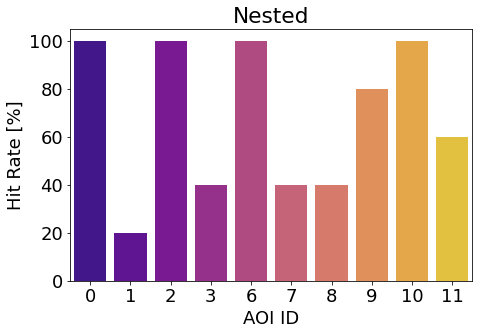

In [4]:
hit_rate_fig = plt.figure(figsize=(7, 5))

# Get the mean hit rate over observers and plot
proportional_hits = hits.groupby("AOI").mean().reset_index()
proportional_hits.loc[:, "hit"] = proportional_hits["hit"] * 100

sns.barplot(x="AOI", y="hit", data=proportional_hits, palette=palette, ax=plt.gca())

plt.title(aoi_layout.capitalize())
plt.xlabel("AOI ID")
plt.ylabel("Hit Rate [%]")

plt.tight_layout()

# Option: uncomment to save your visualisation
# hit_rate_fig.savefig(f'./figures/hit_rate_{aoi_layout}.png');

From this figure, we can see what percentage of observers looked at each AOI. It makes sense to compare this plot with the sizes of AOIs, and the location where they were in the world before drawing any conclusions. If you run this notebook once with the nested, and once with the distributed AOI layout, you will notice some significant differences in this plot.

If you have trouble remembering which AOI ID here corresponds to which painting, you can pull up the notebooks you used to define the [nested][link_to_nested] or [distributed][link_to_distributed] AOIs right next to this - the numbers visualized on the AOIs there will match the ID here.

## Time to First Contact
Time to First Contact measures how long it took observers to look at an AOI for the first time. Short times to first contact mean that the observers looked at the AOI early during the section.

We can compute time to first contact as the difference between the time when the first fixation was registered on an AOI and the time when the section started. So first, we need the information when each section started.

## Import Section Data
To perform this analysis we need to load another file from the Reference Image Mapper - the sections. Sections contain some extra information about the recording - like the time when they started, which is exactly what we need here.

In [5]:
# loading sections if the layout was nested (only one file)
if aoi_layout == "nested":
    sections = pd.read_csv(f"{path_to_reference_image_mapper}/sections.csv")
# loading sections if the layout was distributed (multiple files, requires looping)
elif aoi_layout == "distributed":
    sections = pd.DataFrame()
    for directory in os.listdir(path_to_reference_image_mapper):
        one_section = pd.read_csv(
            f"{path_to_reference_image_mapper}/{directory}/sections.csv"
        )
        sections = (
            pd.concat([sections, one_section]).drop_duplicates().reset_index(drop=True)
        )

sections.head()

,section id,recording id,recording name,wearer id,wearer name,section start time [ns],section end time [ns],start event name,end event name
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,Steven_Standing_Downstairs,f81c3eee-3970-40d1-84a5-6732c8ef2d75,Steven,1636035560120000000,1636035572525000000,multiple_paintings_start,multiple_paintings_end
1,89011032-f86b-41fa-a7c7-1c39e734113a,95833eee-cc7c-41ad-a242-b0db2e421866,Jack_Standing_Downstairs,539b9eee-bf45-4512-bbb1-05ae07a71517,Jack,1635864181664000000,1635864196355000000,multiple_paintings_start,multiple_paintings_end
2,701607c8-fd13-4c98-b5cd-2bf7e1b5818a,b1eafeee-a388-4c85-86a4-fa855bc4bea3,Anna_Standing_Downstairs,e4184eee-9fb8-452a-9ba7-05db8471a5af,Anna,1636382551779000000,1636382577933000000,multiple_paintings_start,multiple_paintings_end
3,93f3ae11-30aa-45a9-b5bd-57b0ed6bad95,c9431eee-9299-4234-81b7-1df1e3e6e97c,Susan_Standing_Downstairs,82efdeee-17e3-476d-9e18-3e05a3228b85,Susan,1636386863776000000,1636386886095000000,multiple_paintings_start,multiple_paintings_end
4,5ee66696-5b84-4814-bb13-b96dee92dfba,737e9eee-89e5-4d1b-9b06-57d84e51eaca,Michelle_Standing_Downstairs,737c0eee-701a-4579-8457-9c7eb26dc0b6,Michelle,1636634036249000000,1636634060648000000,multiple_paintings_start,multiple_paintings_end


## Align Timestamps to Section Start
Now we can compute the difference between each time stamp and the time when the corresponding section started.

In [6]:
# create a new column in the fixation dataframe
fixations["aligned timestamp [s]"] = None

# compute the difference for the respective section
for section in sections["section id"]:
    section_idx = fixations[fixations["section id"] == section].index
    section_start_time = sections.loc[
        sections["section id"] == section, "section start time [ns]"
    ].values
    # update the value of the aligned time stamp
    fixations.loc[section_idx, "aligned timestamp [s]"] = (
        fixations.loc[section_idx, "start timestamp [ns]"] - section_start_time
    ) / 1e9

## Extract Time to First Contact
Next, we aggregate the fixation data by section id and AOI, and extract the lowest value from the "aligned timestamp [s]" column. This is the time when the very first fixation on that AOI appeared in this session.

In [7]:
first_contact = pd.DataFrame(
    fixations.groupby(["section id", "AOI"]).min()["aligned timestamp [s]"]
)
first_contact.reset_index(inplace=True)
# make sure the AOI field is an interger
first_contact["AOI"] = first_contact["AOI"].astype(int)

first_contact.head()

,section id,AOI,aligned timestamp [s]
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,0,2.848527
1,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,2,0.656495
2,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,6,0.136652
3,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,7,0.888558
4,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,10,4.696511


## Visualize Time to First Contact

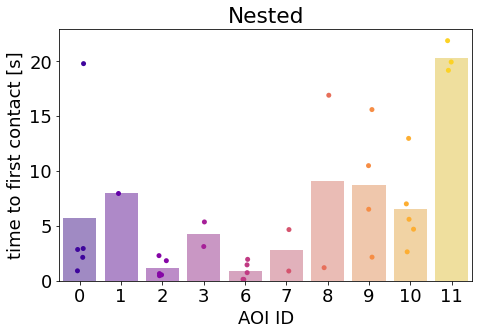

In [8]:
# create the figure
first_contact_fig = plt.figure(figsize=(7, 5))

# plot the mean values as bar plots
sns.barplot(
    x="AOI",
    y="aligned timestamp [s]",
    data=first_contact,
    palette=palette,
    ci=None,
    ax=plt.gca(),
    alpha=0.5,
)
# add individual data as dots
sns.stripplot(
    x="AOI",
    y="aligned timestamp [s]",
    data=first_contact,
    palette=palette,
    ax=plt.gca(),
)
# set title and axis labels
plt.title(aoi_layout.capitalize())
plt.ylabel("time to first contact [s]")
plt.xlabel("AOI ID")

plt.tight_layout()
# first_contact_fig.savefig(f'./figures/first_contact_{aoi_layout}.png');

Let's break down what happens in this plot: 

The bars show us the mean Time to First Contact in seconds. Each bar represents one AOI. That means the higher they are, the longer it took our observers on average to look at this AOI.

But the mean value sometimes hides some interesting features in the distribution of our data. That's why on top of the mean values, we plot the Times to First Contact for every individual observer - the single dots that you can see in the plot. This helps you to identify outliers, or can show you if there are any clusters in your data - all of this would be hidden if we'd only show the mean value or standard deviations. 

## Dwell Time

Dwell Time describes the total time an observer has looked at a given AOI. We can find the dwell time by summing up the durations of all fixations we detected, seperately for each AOI. Again, we group our data frame, and then sum up all the fixation duration we recorded during our study.

In [9]:
dwell = fixations.groupby(["section id", "AOI"]).sum()["duration [ms]"]
dwell = pd.DataFrame(dwell).sort_values("AOI")
dwell.reset_index(inplace=True)

# translate the dwell time in milliseconds to seconds
dwell["duration [s]"] = dwell["duration [ms]"] / 1000

# make sure the AOI field is an interger
dwell["AOI"] = dwell["AOI"].astype(int)

dwell.head()

,section id,AOI,duration [ms],duration [s]
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,0,544.0,0.544
1,701607c8-fd13-4c98-b5cd-2bf7e1b5818a,0,1016.0,1.016
2,5ee66696-5b84-4814-bb13-b96dee92dfba,0,312.0,0.312
3,93f3ae11-30aa-45a9-b5bd-57b0ed6bad95,0,2149.0,2.149
4,89011032-f86b-41fa-a7c7-1c39e734113a,0,1003.0,1.003


## Visualize Dwell Time
We will visualize Dwell Time in the same way that we visualized Time to First Contact above.

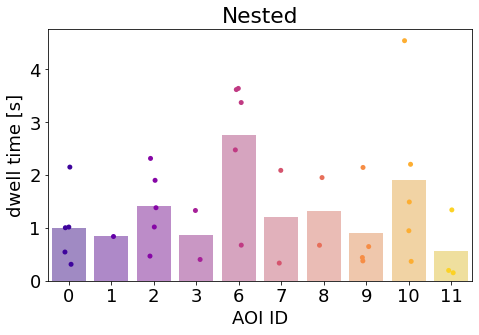

In [10]:
# plot the average time spent on each image
dwell_time_fig = plt.figure(figsize=(7, 5))

sns.barplot(
    x="AOI",
    y="duration [s]",
    data=dwell,
    palette=palette,
    ci=None,
    ax=plt.gca(),
    alpha=0.5,
)

sns.stripplot(x="AOI", y="duration [s]", data=dwell, palette=palette, ax=plt.gca())

plt.title(aoi_layout.capitalize())
plt.ylabel("dwell time [s]")
plt.xlabel("AOI ID")
plt.tight_layout()

# Option: uncomment to save your visualisation
# dwell_time_fig.savefig(f'./figures/dwell_time_{aoi_layout}.png');

This graph can be read similar to the Time to First Contact graph above - the higher a bar, the more, or the longer fixations observers made on this AOI. The distribution is revealed by the individual dots.

## The End ... of our Examples

There are many many other ways in which we could dive even deeper! We could correlate gaze metrics for observers, or investigated if longer dwell times where caused by more, or by longer fixations.

Maybe you have your own question in mind? 

Or maybe, you just want to go back and dig through all the data in our [Demo Workspace][workspace_link].

Whatever you decide to do, thanks for coding along! Feel free to share any interesting discoveries or pressing questions with the Pupil Invisible community - we love seeing how you get creative.

[workspace_link]: https://cloud.pupil-labs.com/workspace/78cddeee-772e-4e54-9963-1cc2f62825f9